In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import os
import pydicom
from glob import glob
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [84]:
import ast
import matplotlib.patches as ptc


In [44]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    # not sure why this is done? 
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

def plot_img(img_path, size = (7,7), cmap = 'gray'):
    img = read_xray(img_path)
    plt.figure(figsize=size)
    plt.imshow(img, cmap = cmap)
    plt.show()

Lets look how many files we have in train and test folder.

In [2]:
test = os.listdir("../input/siim-covid19-detection/test")
train = os.listdir("../input/siim-covid19-detection/train")
print(len(test))
print(len(train))

1214
6054


In [7]:
train_path = glob("../input/siim-covid19-detection/train/**/*.dcm", recursive=True)
test_path = glob("../input/siim-covid19-detection/test/**/*.dcm", recursive= True)

In [12]:
print(len(test_path))
print(len(train_path))

1263
6334


The number of folders are lesser than number of dcm files which means some patients have multiple chest Xrays.

In [13]:
#CSV file
train_image_level = pd.read_csv("../input/siim-covid19-detection/train_image_level.csv")

In [15]:
train_image_level.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [22]:
train_image_level.describe()

,id,boxes,label,StudyInstanceUID
count,6334,4294,6334,6334
unique,6334,4294,4295,6054
top,f2a37ea4c3f3_image,"[{'x': 724.33376, 'y': 552.83944, 'width': 809...",none 1 0 0 1 1,0fd2db233deb
freq,1,1,2040,9


6054 unique paients have 6334 Chest Xrays. 2040 patients do not have any bounding box which mean they are normal controls Xrays. 

In [29]:
len(np.unique(train_image_level[train_image_level.label == 'none 1 0 0 1 1'].StudyInstanceUID))

1937

In [91]:
train_image_level[train_image_level.StudyInstanceUID == '5776db0cec75'].label.values[0]

'opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472'

1937 are healthy controls. 

In [53]:
glob("../input/**/5776db0cec75/**/*.dcm", recursive=True)

['../input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm']

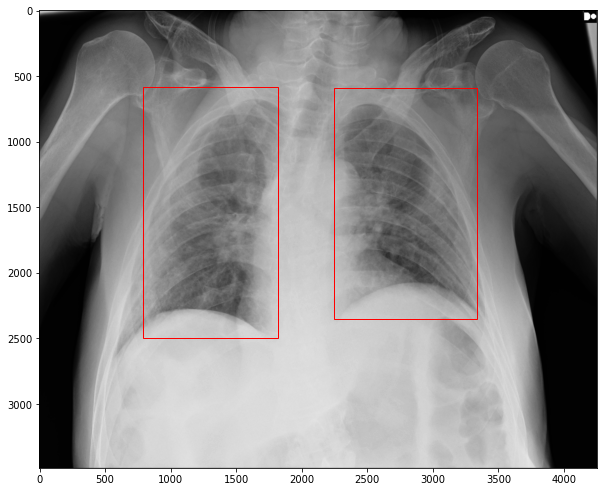

In [86]:
img = read_xray(['../input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm'][0])
fig, ax = plt.subplots(1, figsize = (10,10))
ax.imshow(img, cmap = 'gray')

for i in (ast.literal_eval(train_image_level[train_image_level.StudyInstanceUID == '5776db0cec75'].boxes.values[0])):
    rect = ptc.Rectangle((i['x'],i['y']), height=i['height'], width = i['width'], linewidth = 1, edgecolor = 'r', facecolor = 'none')
    ax.add_patch(rect)
    
plt.show()
    



In [31]:
train_image_level[train_image_level.StudyInstanceUID == '0fd2db233deb']

,id,boxes,label,StudyInstanceUID
130,04cc2f7f4c4b_image,NaN,none 1 0 0 1 1,0fd2db233deb
156,05c063f5cef5_image,NaN,none 1 0 0 1 1,0fd2db233deb
551,156cb1f5c689_image,NaN,none 1 0 0 1 1,0fd2db233deb
964,26f643772090_image,"[{'x': 561.30269, 'y': 163.28797, 'width': 883...",opacity 1 561.30269 163.28797 1445.02377 1495....,0fd2db233deb
1861,4c414b793562_image,NaN,none 1 0 0 1 1,0fd2db233deb
4044,a5a364383f34_image,NaN,none 1 0 0 1 1,0fd2db233deb
4340,b121806162c3_image,NaN,none 1 0 0 1 1,0fd2db233deb
4698,bee62c601ae9_image,NaN,none 1 0 0 1 1,0fd2db233deb
4902,c6e92e59a0ae_image,NaN,none 1 0 0 1 1,0fd2db233deb


In [48]:
glob("../input/siim-covid19-detection/train/0fd2db233deb/**/*.dcm", recursive=True)

['../input/siim-covid19-detection/train/0fd2db233deb/ad6876d5e56a/bee62c601ae9.dcm',
 '../input/siim-covid19-detection/train/0fd2db233deb/b8c20a915593/a5a364383f34.dcm',
 '../input/siim-covid19-detection/train/0fd2db233deb/06feab2c43b9/05c063f5cef5.dcm',
 '../input/siim-covid19-detection/train/0fd2db233deb/6986b53f6431/4c414b793562.dcm',
 '../input/siim-covid19-detection/train/0fd2db233deb/f759743147f8/04cc2f7f4c4b.dcm',
 '../input/siim-covid19-detection/train/0fd2db233deb/a4fec64f5b97/156cb1f5c689.dcm',
 '../input/siim-covid19-detection/train/0fd2db233deb/01050ddc661b/c6e92e59a0ae.dcm',
 '../input/siim-covid19-detection/train/0fd2db233deb/9025f953c3d2/26f643772090.dcm',
 '../input/siim-covid19-detection/train/0fd2db233deb/2019d0f0cd58/b121806162c3.dcm']